# 1D function models

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from tqdm.notebook import tqdm
import pandas as pd

from physics_mi.utils import set_all_seeds

In [3]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 3243091524  # this one is very interesting
# pleasingly_symmetric_seed = 95433229
set_all_seeds(seed)
print(seed)

247573167


In [465]:
class config:
    # Polynomial model(s)
    POLY_ORDER = 20
    N_FUNCS = 10
    TRAIN_SIZE = 8000
    VALID_SIZE = 2000
    MODELS_PER_FUNC = 50
    MODEL_HIDDEN_DIM = 64

    # Embedder model
    N_SAMPLES = 32
    EPOCHS = 200

## Train source models

Not sure what to call these - so many models to refer to. These are the ones I'm going to classify.

In [5]:
from physics_mi.eval import *


def generate_polynomial(n=20):
    coeffs = np.random.rand(n) * 2 - 1
    return np.polynomial.Polynomial(coeffs)


def plot_funcs(funcs):
    _, axes = plt.subplots(2, 5, figsize=(15, 6))

    x = np.linspace(-1, 1, 100)
    for i, (ax, func) in enumerate(zip(axes.flatten(), funcs)):
        ax.plot(x, func(x))
        ax.set_title(f"Function {i}")


def generate_X(size):
    return np.random.rand(size) * 2 - 1


class PolynomialData:
    def __init__(self, func: np.polynomial.Polynomial, size: int) -> None:
        self.func = func
        self.size = size
        self.X = generate_X(size)
        self.Y = self.func(self.X)
        self.torchify_data()

    def torchify_data(self):
        self.X = torch.as_tensor(self.X).float()[:, None]
        self.Y = torch.as_tensor(self.Y).float()[:, None]


def generate_polynomial_data(funcs, train_size, valid_size):
    return [
        {
            "train": PolynomialData(func, train_size),
            "valid": PolynomialData(func, valid_size),
        }
        for func in funcs
    ]


class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)


def get_model():
    return Net(input_dim=1, hidden_dim=config.MODEL_HIDDEN_DIM, output_dim=1)


def train_model(train_data, valid_data):
    N = 100  # number of epochs

    model = Net(input_dim=1, hidden_dim=config.MODEL_HIDDEN_DIM, output_dim=1)
    loss_func = nn.MSELoss()
    optimiser = Adam(model.parameters(), lr=1e-1)
    log = []

    for i in range(N):
        log_sample = {}

        # Training update
        model.train()
        model.zero_grad()
        Y_hat = model(train_data.X)
        loss = loss_func(Y_hat, train_data.Y)
        log_sample["train_loss"] = float(loss.detach())
        loss.backward()
        optimiser.step()

        # Validation set
        model.eval()
        Y_hat = model(valid_data.X)
        loss = loss_func(Y_hat, valid_data.Y)
        log_sample["valid_loss"] = float(loss.detach())

        log.append(log_sample)

    log = pd.DataFrame(log)

    return model, log


def get_preds(model, valid_data):
    model.eval()

    with torch.inference_mode():
        out = model(valid_data.X)

    y_preds = out.numpy()[:, 0]
    y_targs = valid_data.Y.numpy()[:, 0]

    return y_preds, y_targs


def plot_models(df, data, title=None):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    pdf = df.reset_index(drop=True)

    for ax, (i, row) in zip(axes.flatten(), pdf.iterrows()):
        model = get_model()
        model.load_state_dict(row["model"])
        valid_data = data[row["func"]]["valid"]

        y_preds, _ = get_preds(model, valid_data)

        sort_idxs = torch.argsort(valid_data.X[:, 0]).numpy()
        x = valid_data.X.numpy()[sort_idxs]
        y = valid_data.Y.numpy()[sort_idxs]
        y_preds_plot = y_preds[sort_idxs]

        ax.scatter(x, y_preds_plot, s=5, label="Predicted", alpha=0.5, color="grey")
        ax.plot(x, y, label="True", color="salmon")

        _ = ax.set_title(f"Function {i}")

    if title is not None:
        fig.suptitle(title)

In [7]:
funcs = [generate_polynomial(config.POLY_ORDER) for _ in range(config.N_FUNCS)]
data = generate_polynomial_data(funcs, train_size=config.TRAIN_SIZE, valid_size=config.VALID_SIZE)

In [ ]:
models = []
for i, (func, func_data) in tqdm(enumerate(zip(funcs, data)), total=len(data)):
    for j in tqdm(range(config.MODELS_PER_FUNC), leave=False):
        model, log = train_model(func_data["train"], func_data["valid"])
        row = {}
        row["func"] = i
        row["repeat"] = j
        row["model"] = model.state_dict()
        row["valid_loss"] = log["valid_loss"].iloc[-1]
        models.append(row)
    print("\n")

mdf = pd.DataFrame(models)

In [7]:
mdf.loc[mdf["repeat"] == 0]

,func,repeat,model,valid_loss
0,0,0,"{'layers.0.linear.weight': [[tensor(-0.5751)],...",0.030437
50,1,0,"{'layers.0.linear.weight': [[tensor(-0.5950)],...",0.054937
100,2,0,"{'layers.0.linear.weight': [[tensor(-0.4562)],...",0.003768
150,3,0,"{'layers.0.linear.weight': [[tensor(0.0124)], ...",0.012442
200,4,0,"{'layers.0.linear.weight': [[tensor(0.6744)], ...",0.013505
250,5,0,"{'layers.0.linear.weight': [[tensor(0.7425)], ...",0.043196
300,6,0,"{'layers.0.linear.weight': [[tensor(0.4191)], ...",0.004019
350,7,0,"{'layers.0.linear.weight': [[tensor(-0.4034)],...",0.001580
400,8,0,"{'layers.0.linear.weight': [[tensor(-0.2494)],...",0.020828
450,9,0,"{'layers.0.linear.weight': [[tensor(0.7286)], ...",0.048902


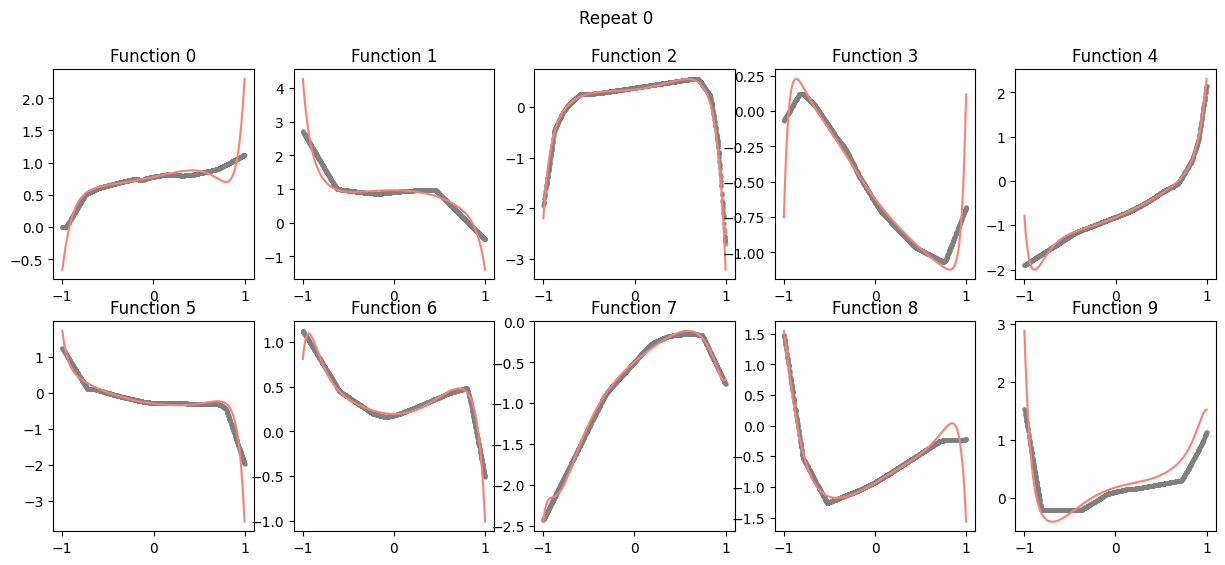

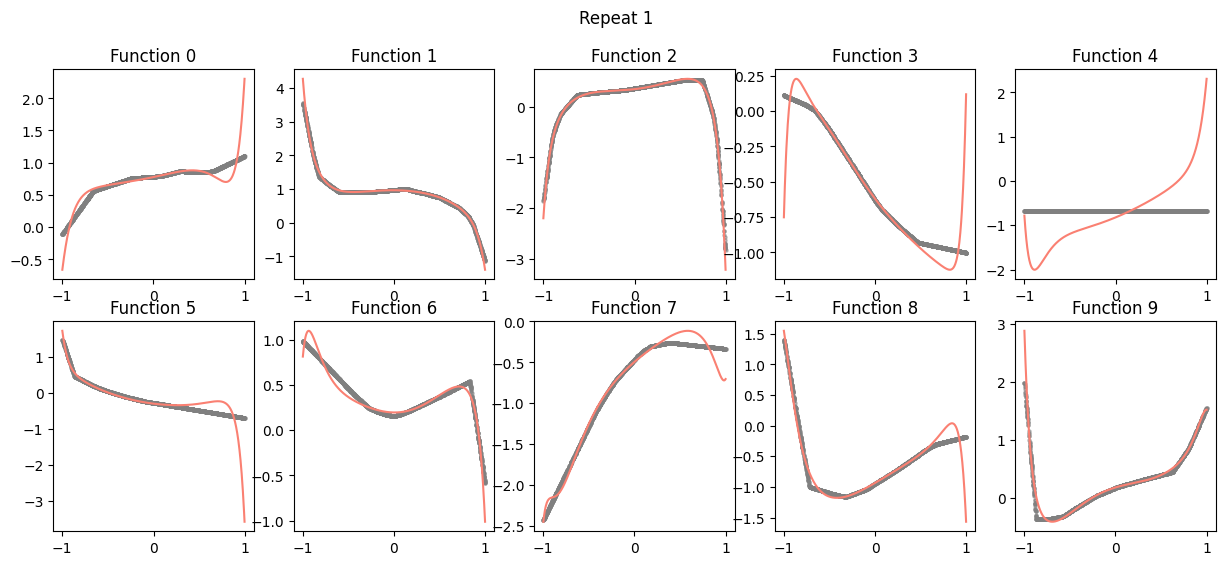

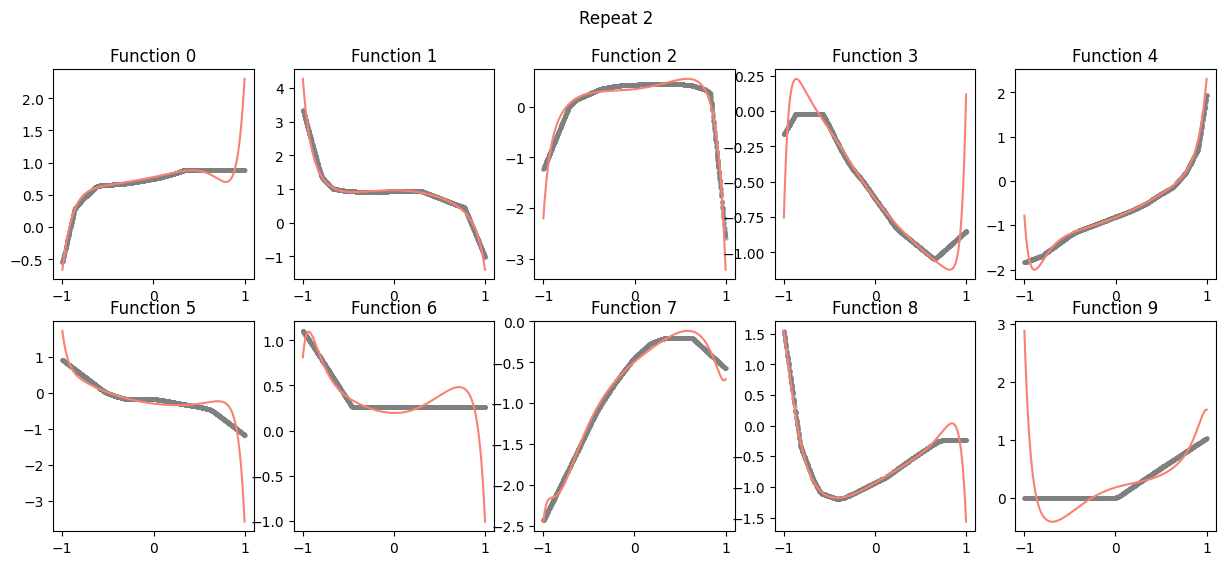

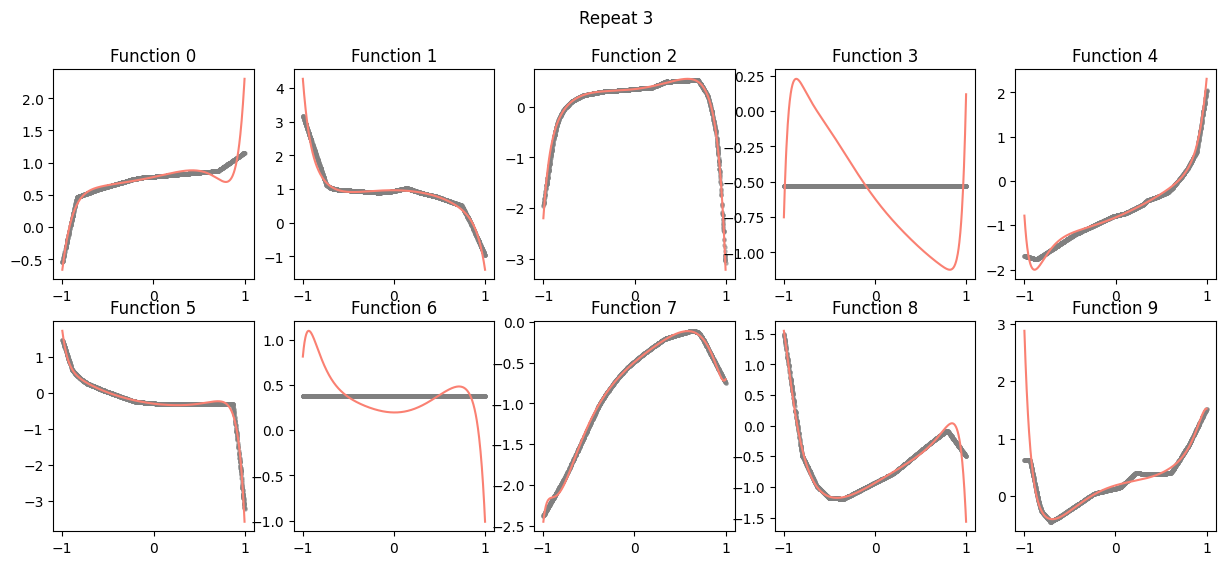

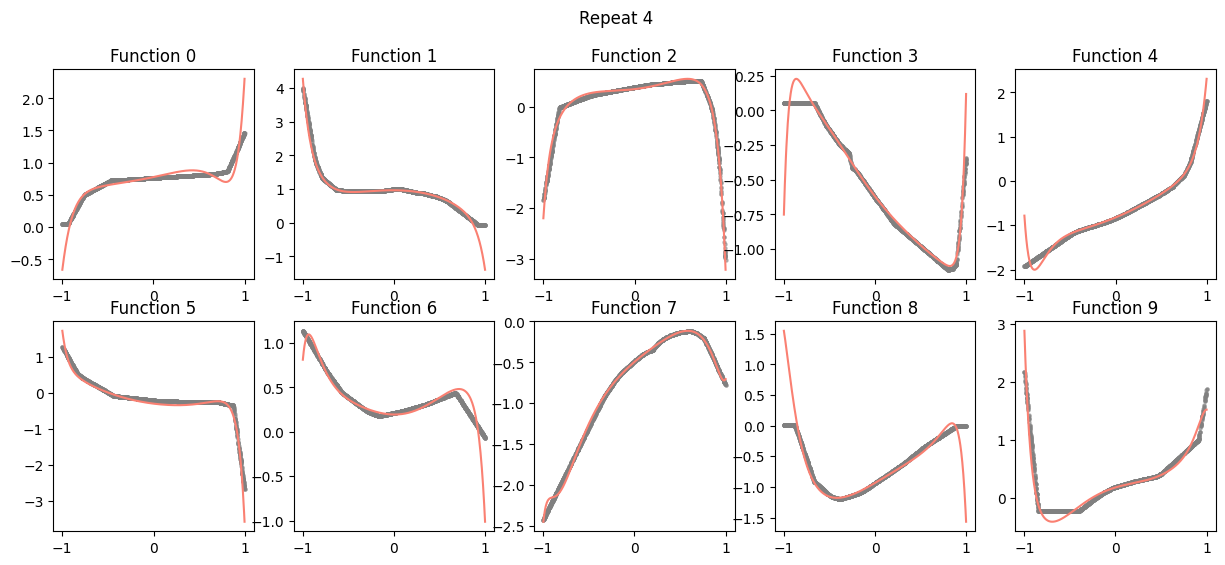

In [8]:
for i in range(5):
    plot_models(mdf.loc[mdf["repeat"] == i], data, title=f"Repeat {i}")

Sometimes there is some training collapse where the model predicts a static value as output, we probably want to avoid this if we're doing a cloze task - we want at least two different line sections per model... Could eliminate with some threshold on the loss but let's see how we go.

It's nice to see our line sections pretty clearly. We just have to hope that there is enough structure for our model to predict them well enough.

I'll need to be careful in the next section to make sure that $n_{samples} < n_{grads}$ because otherwise I can imagine the next model could simply learn to join up the dots linearly between the heavily sampled sections provided as opposed to understanding the underlying function.

In [194]:
# mdf.to_pickle("models/polynomial_models.pkl")

## Train model embedder

Here's where it gets interesting.

So far we've trained 50 different networks to model each of our 10 1D polynomials. The plan now is to use these as training data for our auxiliary model i.e. the one that's going to be generating embeddings. 

### Data

In [8]:
mdf = pd.read_pickle("models/polynomial_models.pkl")

<Axes: >

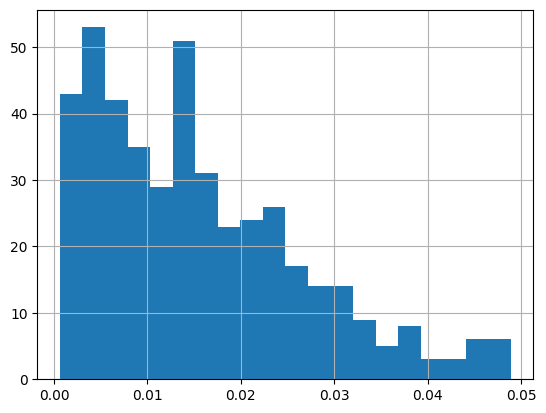

In [9]:
mdf.valid_loss.hist(bins=20)

Let's remove some of those high-loss models that probably aren't going to provide us with enough line sections to learn anything meaningful.

In [10]:
(mdf.valid_loss < 0.05).mean()

1.0

In [11]:
mdf = mdf.loc[mdf.valid_loss < 0.05].reset_index(drop=True)
mdf.groupby("func")["func"].count()

func
0    46
1    42
2    46
3    49
4    47
5    41
6    46
7    48
8    39
9    38
Name: func, dtype: int64

Some functions were obviously harder to model than others.

In [347]:
from physics_mi.utils import unique


class GradientDataset(Dataset):
    def __init__(self, df: pd.DataFrame, n_samples: int = 10):
        self.df = df.reset_index(drop=True)
        self.n_samples = n_samples

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        model = get_model()
        model.load_state_dict(row["model"])
        for param in model.parameters():
            param.requires_grad = False
        X = torch.as_tensor(generate_X(self.n_samples)).float()
        X = torch.sort(X)[0][:, None]
        X.requires_grad_(True)
        out = model(X)
        loss = out.mean()
        loss.backward()
        input_grads = X.grad.clone().detach()
        stack = torch.cat([X, input_grads], dim=1)
        uq_grads, _, _, index = unique(input_grads)
        uq_grads = uq_grads[torch.argsort(index)]
        n_grads = len(uq_grads)
        window_size = int(n_grads // 1.5)
        window_start = np.random.randint(0, n_grads - window_size)
        mask_grads = uq_grads[window_start : window_start + window_size]
        mask = torch.isin(stack[:, 1], mask_grads)
        masked = stack.clone()
        masked[mask, 1] = -1
        x = masked.view(-1)
        y = stack[
            :, 1
        ]  # TODO potentially mask out the y values too in order to focus the loss
        x = x.detach()
        y = y.detach()
        return x, y

In [349]:
from sklearn.model_selection import train_test_split

train_idxs, valid_idxs = train_test_split(
    mdf.index, test_size=0.2, stratify=mdf["func"]
)
mdf["valid"] = False
mdf.loc[valid_idxs, "valid"] = True

mdf.groupby("func")["valid"].value_counts()

func  valid
0     False    37
      True      9
1     False    34
      True      8
2     False    37
      True      9
3     False    39
      True     10
4     False    37
      True     10
5     False    33
      True      8
6     False    37
      True      9
7     False    38
      True     10
8     False    31
      True      8
9     False    30
      True      8
Name: count, dtype: int64

In [350]:
train_ds = GradientDataset(mdf.loc[~mdf["valid"]], n_samples=config.N_SAMPLES)
valid_ds = GradientDataset(mdf.loc[mdf["valid"]], n_samples=config.N_SAMPLES)

len(train_ds), len(valid_ds)

(353, 89)

In [351]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False)

xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([64, 64]), torch.Size([64, 32]))

### Train

In [641]:
from torch.optim.lr_scheduler import OneCycleLR

model = Net(input_dim=64, hidden_dim=64, output_dim=32)
optimiser = Adam(model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()
total_steps = len(train_dl) * config.EPOCHS
scheduler = OneCycleLR(optimiser, max_lr=1e-3, total_steps=total_steps)

log = []

for epoch in tqdm(range(config.EPOCHS)):
    log_sample = {}

    model.train()
    for xb, yb in train_dl:
        y_hat = model(xb)
        mask = xb.view(len(xb), -1, 2)[:, :, 1] == -1
        loss = loss_func(y_hat[mask], yb[mask])
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        scheduler.step()

    model.eval()
    valid_loss = 0
    for xb, yb in valid_dl:
        with torch.no_grad():
            y_hat = model(xb)
            mask = xb.view(len(xb), -1, 2)[:, :, 1] == -1
            valid_loss += nn.MSELoss()(y_hat[mask], yb[mask])

    log_sample["valid_loss"] = float(valid_loss / len(valid_dl))
    log_sample["train_loss"] = float(loss)
    log.append(log_sample)

log = pd.DataFrame(log)

  0%|          | 0/200 [00:00<?, ?it/s]

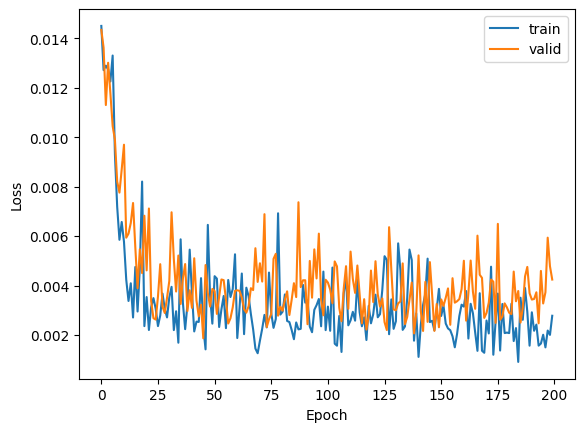

In [642]:
plot_loss(log["train_loss"], log["valid_loss"])

In [643]:
def get_preds(model, valid_dl):
    model.eval()

    X = []
    y_preds = []
    y_targs = []

    for xb, yb in valid_dl:
        with torch.inference_mode():
            out = model(xb)
        X.append(xb)
        y_preds.append(out)
        y_targs.append(yb)

    X = torch.cat(X).numpy()
    y_preds = torch.cat(y_preds).numpy()
    y_targs = torch.cat(y_targs).numpy()

    return y_preds, y_targs, X

In [644]:
y_preds, y_targs, X = get_preds(model, valid_dl)

X_x = X.reshape(len(X), -1, 2)[:, :, 0]
cloze_mask = X.reshape(len(X), -1, 2)[:, :, 1] == -1
y_preds.shape, y_targs.shape, cloze_mask.shape, X_x.shape

((89, 32), (89, 32), (89, 32), (89, 32))

In [645]:
i = 0

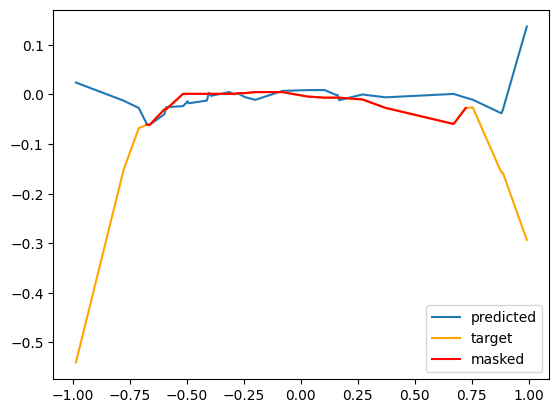

In [660]:
fig, ax = plt.subplots()

func = funcs[valid_ds.df.loc[i, "func"]]

ax.plot(X_x[i], y_preds[i], label="predicted")
ax.plot(X_x[i], y_targs[i], label="target", color="orange")
ax.plot(X_x[i, cloze_mask[i]], y_targs[i, cloze_mask[i]], color="red", label="masked")
_ = ax.legend()
i += 1